In [1]:
import sys
sys.path.append('../')

import hockeypi.glicko2 as glicko2       # credits to pyglicko2
import hockeypi.games as gm
import hockeypi.teams as tm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, timedelta

sns.set()

### Glicko-2 Ratings over the Regular Season: Top, Mid, Bottom Tier Teams

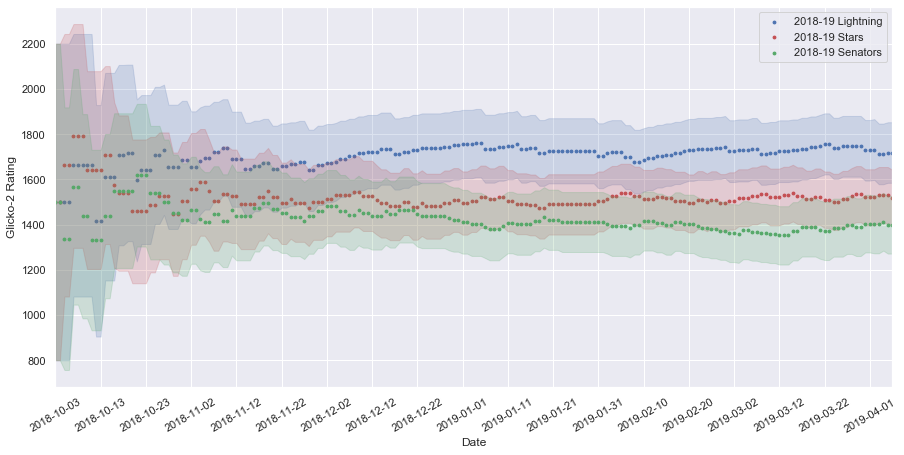

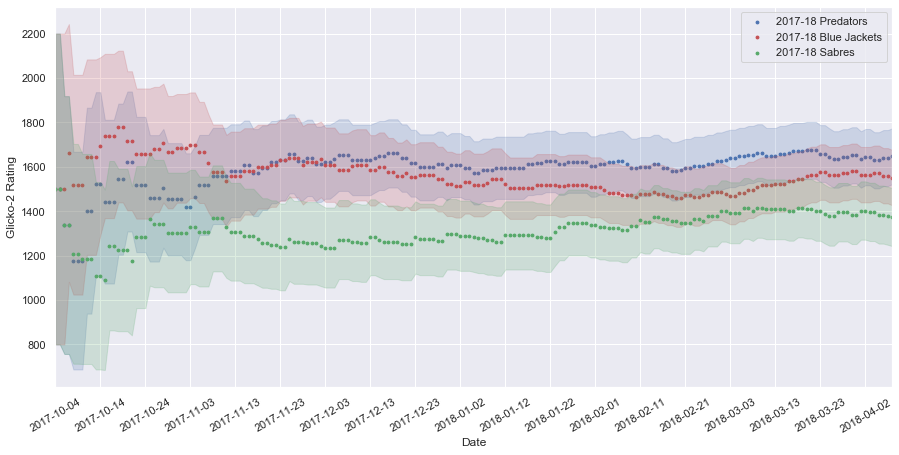

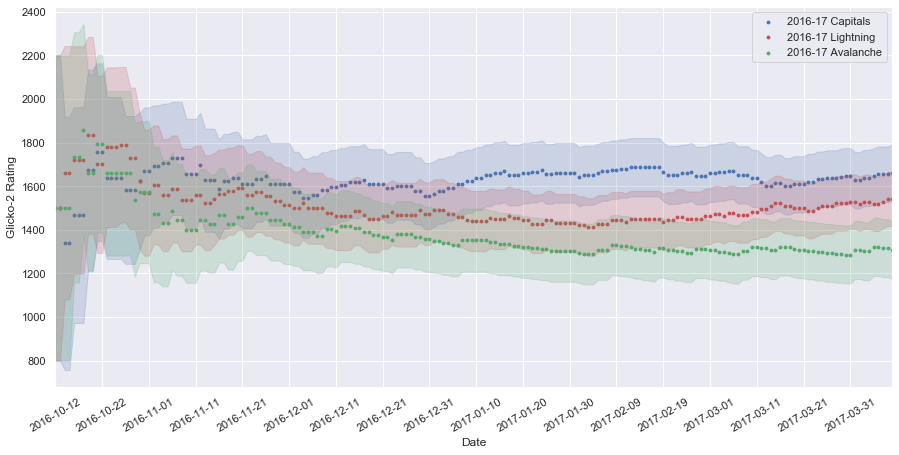

In [5]:
years = [2018, 2017, 2016]

for year in years:
    teams_df = tm.get_all_team_statistics_by_year(year).sort_values(by='pts')
    teams = [get_id_by_place(1, year), get_id_by_place(15, year), get_id_by_place(len(teams_df), year)]
    get_glicko2_over_dates_with_conf(teams, year)

### Glicko2 Methods

In [3]:
class Team:
    '''
    Class for an NHL team that holds the Glicko2 model 
    of the team. The Glicko2 model is initialized with
    a rating of 1500, rating deviation of 300 and a 
    volatility of 0.06, as recommended. 
    '''
    def __init__(self, nhl_id, name):
        self.nhl_id = nhl_id
        self.name = name
        self.model = glicko2.Player()
        
def initialize_models(year):
    '''
    Create an instantitation of a Team class for each team
    playing in a given year's regular season. Returns a
    dictionary of team_ids to respective Team classes. 
    '''
    df = tm.get_teams_by_year(year)
    teams = {}
    for idx, row in df.iterrows():
        nhl_id = row['teamId']
        name = f"{row['locationName']} {row['teamName']}"
        teams[nhl_id] = Team(nhl_id, name)
    return teams

def get_regular_season_df(year):
    '''
    Get all regular season games for a given year.
    '''
    df = gm.get_all_games_by_year(year)
    df_reg = df[df['gameType'] == 'R'].sort_values(by='date').reset_index()
    return df_reg

def get_team_name_by_id(team_id, year):
    '''
    Given a team name and the year of play, return the 
    NHL specified team ID. 
    '''
    df_teams = tm.get_teams_by_year(year)
    return df_teams[df_teams['teamId'] == team_id]['teamName'].item()

def get_season_dates(year):
    '''
    Get a list of dates for the year's regular season.
    '''
    df_reg = get_regular_season_df(year)
    start_date_ymd = df_reg['date'].to_list()[0].split('-')
    start_date = date(int(start_date_ymd[0]), int(start_date_ymd[1]), int(start_date_ymd[2]))
    end_date_ymd = df_reg['date'].to_list()[-1].split('-')
    end_date = date(int(end_date_ymd[0]), int(end_date_ymd[1]), int(end_date_ymd[2]))

    dates = []
    delta = end_date - start_date 
    for i in range(delta.days + 1):
        day = start_date + timedelta(days=i)
        dates.append(day)
    return dates 

def get_id_by_place(place, year):
    '''
    Get the NHL team id for the team that had the specified
    rank in the regular season. 
    '''
    teams_df = tm.get_all_team_statistics_by_year(year).sort_values(by='pts')
    return teams_df.tail(place).head(1)['teamId'].item()

def simulate_season(year):
    '''
    Simulate the regular season, recording the Glicko2 
    rating, rating deviation and volatility with daily
    granularity. 
    '''
    team_stats_by_date = {}
    df_reg = get_regular_season_df(year)
    teams = initialize_models(year)
    dates = get_season_dates(year)

    for d in dates:
        # Update team stats for the date
        team_stats = {} 
        team_ids = tm.get_teams_by_year(year)['teamId'].to_list()
        for team_id in team_ids:
            team_stats[team_id] = {
                    'rating': teams[team_id].model.getRating(),
                    'rd': teams[team_id].model.getRd(),
                    'vol': teams[team_id].model.vol
                }
        team_stats_by_date[d] = team_stats

        # Run daily simulation
        games = df_reg[df_reg['date'] == str(d)]
        for idx, row in games.iterrows(): 
            home_id = row['homeId']
            away_id = row['awayId']
            home_rating = teams[home_id].model.getRating()
            home_rd = teams[home_id].model.getRd()
            away_rating = teams[away_id].model.getRating()
            away_rd = teams[away_id].model.getRd()

            if row['homeScore'] > row['awayScore']:
                teams[home_id].model.update_player([away_rating], [away_rd], [1])
                teams[away_id].model.update_player([home_rating], [home_rd], [0])
            else:
                teams[home_id].model.update_player([away_rating], [away_rd], [0])
                teams[away_id].model.update_player([home_rating], [home_rd], [1])
    return team_stats_by_date

def get_glicko2_over_dates_with_conf(team_ids, year, figsize=(15,7)):
    '''
    Get the Glicko-2 rating of the specified teams, alongside
    their respective 95% confidence intervals with daily granularity.
    '''
    dates = get_season_dates(year)
    team_stats_by_date = simulate_season(year)
    
    plt.figure(figsize=figsize)
    plt.xlabel('Date')
    plt.xticks(dates[::10], [str(el) for el in dates[::10]], rotation=30)
    plt.xlim([dates[0], dates[-1]])
    plt.ylabel('Glicko-2 Rating')
    c_list, c_idx = ['b', 'r', 'g', 'm', 'c'], 0
    
    for team_id in team_ids:
        team_glicko2_stats = [team_stats_by_date[date][team_id] for date in dates]
        ratings = [el['rating'] for el in team_glicko2_stats]
        ratings_max = [el['rating'] + 2*el['rd'] for el in team_glicko2_stats]
        ratings_min = [el['rating'] - 2*el['rd'] for el in team_glicko2_stats]
        plt.scatter(x=dates, y=ratings, s=8, c=c_list[c_idx % len(c_list)], \
                    label=f'{year}-{str(year+1).replace("20", "")} {get_team_name_by_id(team_id, year)}')
        plt.fill_between(dates, ratings_min, ratings_max, color=c_list[c_idx % len(c_list)], alpha=0.2)
        c_idx += 1
        
    plt.legend()
    plt.show()